In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
import datetime
import pandas as pd
import matplotlib.dates as mdates
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics import tsaplots
import statsmodels.tsa

In [5]:
# Hedge Fund

df = pd.read_csv('hedge-fund-NAVROR-daily.csv', skiprows=2)

df['Date'] = pd.to_datetime(df.Date)

#S&P 500

sp_df = pd.read_csv('S&P 500 OHCL Data.csv').iloc[::-1]
sp_df.Date = pd.to_datetime(sp_df.Date, infer_datetime_format=True)
mask = sp_df.Date > pd.Timestamp(datetime.date(year=2001, month=6, day=8))
sp_df = sp_df.loc[mask]

In [6]:
df.head()

,Date,CCY,NAV,ROR,CCY.1,NAV.1,ROR.1,CCY.2,NAV.2,ROR.2,CCY.3,NAV.3,ROR.3,CCY.4,NAV.4,ROR.4,CCY.5,NAV.5,ROR.5
0,2020-06-08,USD,1405.94,0.22%,USD,1639.25,-0.01%,USD,1145.41,-0.02%,USD,1764.73,0.89%,USD,988.28,0.10%,USD,1240.18,0.05%
1,2020-06-07,USD,1402.83,0.00%,USD,1639.40,0.00%,USD,1145.59,0.00%,USD,1749.20,0.00%,USD,987.34,0.00%,USD,1239.56,0.00%
2,2020-06-06,USD,1402.83,0.00%,USD,1639.40,0.00%,USD,1145.59,0.00%,USD,1749.20,0.00%,USD,987.34,0.00%,USD,1239.56,0.00%
3,2020-06-05,USD,1402.83,0.71%,USD,1639.40,0.95%,USD,1145.59,0.35%,USD,1749.20,1.39%,USD,987.34,-0.66%,USD,1239.56,0.15%
4,2020-06-04,USD,1392.99,0.02%,USD,1623.98,0.14%,USD,1141.61,0.06%,USD,1725.17,-0.14%,USD,993.89,-0.05%,USD,1237.70,0.29%


In [7]:
from functools import reduce

In [14]:
# Function to filter dates 

def filter_for_common_dates(dfs):
    from functools import reduce
    
    common_dates = sorted(reduce(lambda x, y: set(x).intersection(set(y)), [df.Date for df in dfs]))
    
    df_maps = []
    for df in dfs:
        df_map = {}
        for i, row in df.iterrows():
            df_map[row.Date] = i
        df_maps.append(df_map)
    
    df_return = []
    for i, df in enumerate(dfs):
        df_map = df_maps[i]
        mask = []
        for date in common_dates:
            mask.append(df_map[date])
        mask = np.array(mask)
        df_return.append(df.iloc[mask])
    
    return [df.reset_index(drop=True) for df in df_return]

df, sp_df = filter_for_common_dates([df, sp_df])

In [20]:
gsl_open = (df['NAV.2'])
sp_open = sp_df['Open']

def returns(a, b):
    return ((float(a) - float(b)) / (float(b) - 1))

def create_initial_array(return_period):

    gsl_ret = []
    sp_ret = []

    for i in range (0, len(gsl_open)- return_period, return_period):
        gsl_ret.append(returns(gsl_open[i + return_period], gsl_open[i]))
        sp1= float(sp_open[i+return_period].replace(',',''))
        sp2= float(sp_open[i].replace(',',''))
        sp_ret.append(returns(sp1,sp2))



    initial_array = np.array([[gsl_ret], [sp_ret]])
    initial_array = np.reshape(initial_array, ((initial_array.shape[0]*initial_array.shape[1]), initial_array.shape[2]))
    return(initial_array)

return_period = 1
initial_array = create_initial_array(return_period)



In [21]:
def autocorrelation_calculations(a , b): 
    d = list(statsmodels.tsa.stattools.ccf(a,b))
    return(d[1])

In [22]:
# Subdivision code to divide the initial array of all data points into smaller arrays of n_assets*period_length, where period can be user inputed. Each array created per period will have the autocorrelation_calculation function applied on it to return the autocorrelation at lag 1. The function will append this value to an empty to list that will at the end, contain the autocorrelation values of all periods, a seperate list will be created with corresponding dates.;

def time_duration_autocorrelation(return_length, period, scarray):

    # Initializing lists that will be returned in function
    ac_list = []
    count_list = []
    gsl_ac = []
    sp_ac = []


    # Variables needed to keep track of certain counts and loops, count is to help check if period has ended, i is for the return data range, and periods tracks        what period the code is running at
    period_len = int(period / return_length)
    count = 1
    periods = 0
    i = 1

    #Creating ranges for the loops
    n_assets, n_time_periods = scarray.shape

    #While loop over whole time period to keep the subdivision running over all periods
    while i <= (n_time_periods - period_len - 1):
        # If statement check to reset the array after each period has ended
        if count % period == 0:
            subdivided_array = np.array([[]])
        # Below loops create the data array for each period that is length n_assets*period_length
        for c in range ((i), (i + period_len)):
            gsl_ac.append(scarray[0, c])

        for n in range (i, (i + period_len)):
            sp_ac.append(scarray[1, n])

        # Editing initial data lists and resetting loop

        ac_list.append((autocorrelation_calculations(gsl_ac, sp_ac)))
        count_list.append(count)
        gsl_ac = []
        sp_ac = []
        i = i + 1
        count += 1

    return(ac_list, count_list)

0.21081851067789195


Text(0, 0.5, 'Cross-correlation Coefficient')

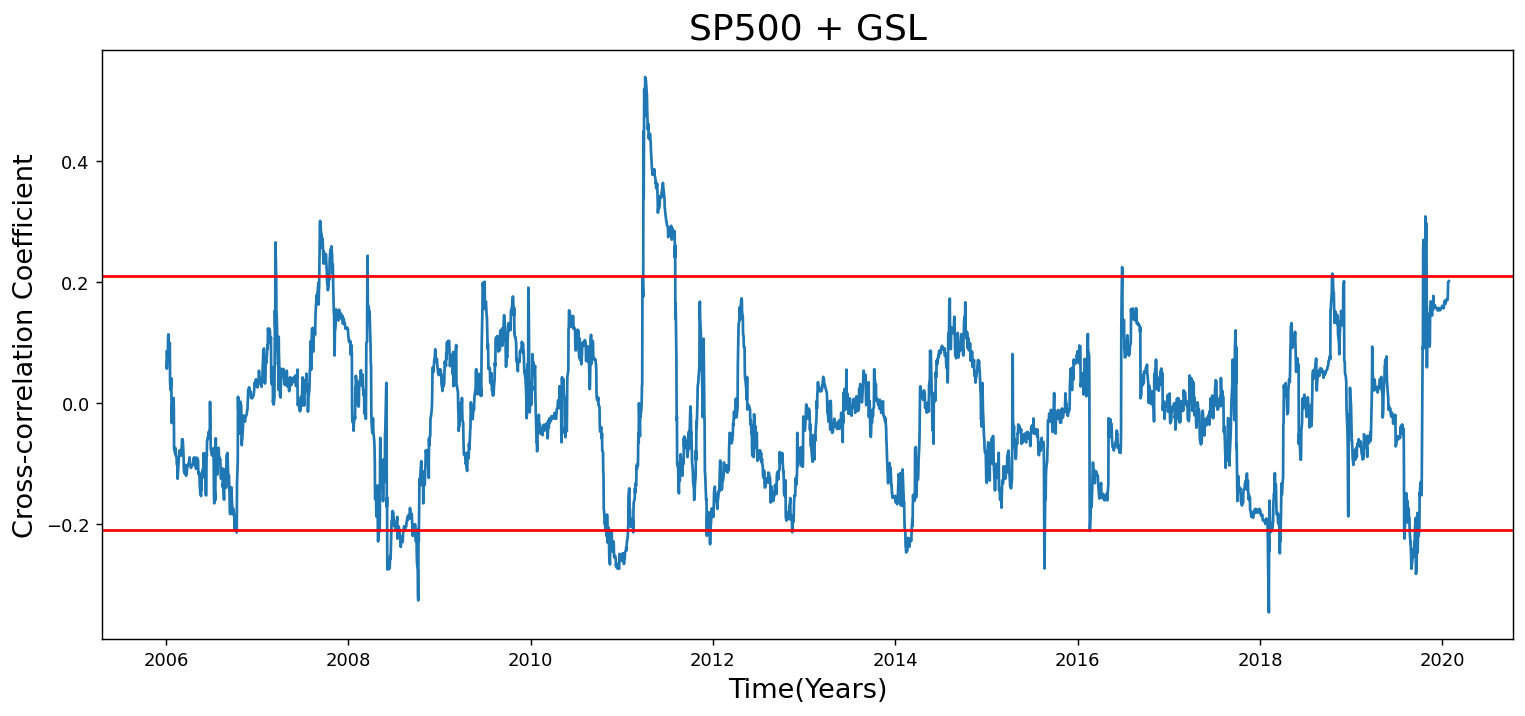

In [23]:
#Plotting Autocorrelation Values per day  from 2000-2020

ac, count = time_duration_autocorrelation(return_period, 90, initial_array)

a = []
df_list = list(df['Date'])
for l in range(0, len(ac)):
    a.append(df_list[l])

# significance level: https://stackoverflow.com/questions/51563711/how-to-plot-confidence-intervals-for-stattools-ccf-function
lags = 90
sig_level = 2 / np.sqrt(lags)

print(sig_level)

plt.figure(figsize = (14,6), dpi = 130)
plt.plot(a, ac)

plt.axhline(y = sig_level, color = 'red')
plt.axhline(y = -sig_level, color = 'red')

plt.title("SP500 + GSL", fontsize = 20)
plt.xlabel("Time(Years)", fontsize = 15)
plt.ylabel("Cross-correlation Coefficient", fontsize = 15)

[ 0.  -0.5  0.5  0.5 -0.5]
[1 2 3 2 1]
[ 0.   -0.75  0.5   0.75 -1.5 ]
[ 0.5   0.75 -1.5 ]
[ 0.5   0.75 -1.5 ]
